In [84]:
import os
os.chdir('D:/EPFL/ML/projects/nerve-segmentation/')
print(os.getcwd())

D:\EPFL\ML\projects\nerve-segmentation


In [85]:
import numpy as np
from tensorflow import keras
import math
import random
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops, regionprops_table
from tensorflow import keras

from src.eval import get_model_prediction

In [86]:
def get_samples(data_folder, test=False, num_samples=1, shuffle=True):
    img_folder = data_folder + '/images'
    img_paths = [img_folder + '/' + img_file for img_file in os.listdir(img_folder)]
    if not test:
        mask_folder = data_folder + '/annotations'
        mask_paths = [mask_folder + '/' + mask_file for mask_file in os.listdir(mask_folder)]
    
        paths = list(zip(img_paths, mask_paths))
        if shuffle:
            random.shuffle(paths)
    else:
        paths = img_paths
        
    if num_samples == -1:
        num_samples = len(paths)
    return paths[:num_samples]

In [87]:
def calculate_iou(pred, mask):
    iou = keras.metrics.MeanIoU(num_classes=2)
    iou.update_state(pred, mask)
    iou_score = np.round(iou.result().numpy(), decimals=2)
    
def calculate_regions(pred, mask=None):
    regions_pred = regionprops(label(((1 - pred) * 255).astype(int)))
    regions_pred = [x for x in regions_pred if x.area > 15]
    
    if mask is not None:
        regions_mask = regionprops(label(((1 - mask) * 255).astype(int)))
        return (regions_pred, regions_mask)
    else:
        return (regions_pred, None)

In [88]:
def show_prediction(img_path, trained_model_checkpoint=None, save=False, show=True):
    if trained_model_checkpoint is not None:
        trained_model = keras.models.load_model(trained_model_checkpoint)
        
    img = np.load(img_path)
    pred = get_model_prediction(trained_model, np.expand_dims(img, axis=0))[0, :, :]
    
    if save:
        output_folder = os.path.join(os.getcwd(), 'results/visualisations/prediction')
        os.makedirs(output_folder, exist_ok=True)
        fname = img_path.rsplit('/', 1)[-1].rsplit('.', 1)[0]
        out_fname = os.path.join(output_folder, fname)
    
    fig, axs = plt.subplots(1,3, figsize=(12, 12))
    axs[0].imshow(img)
    axs[0].set_title('Original image')
    axs[1].imshow(pred, cmap = 'gray', interpolation = 'none')
    axs[1].set_title('Predicted fascicles')
    axs[2].imshow(img)
    axs[2].imshow(pred, cmap = 'gray', alpha = 0.3,interpolation = 'none')
    axs[2].set_title('Predicted fascicles overlayed \nonto the original image')
    
    if save:
        plt.savefig(out_fname + '_predicted.jpg')
    if show:
        plt.show()

In [89]:
def show_mask_and_prediction(img_path, mask_path, trained_model_checkpoint=None, save=False, show=True):
    if trained_model_checkpoint is not None:
        trained_model = keras.models.load_model(trained_model_checkpoint)
    
    if save:
        output_folder = os.path.join(os.getcwd(), 'results/visualisations/prediction_with_mask')
        os.makedirs(output_folder, exist_ok=True)
        fname = img_path.rsplit('/', 1)[-1].rsplit('.', 1)[0]
        out_fname = os.path.join(output_folder, fname)
    
    img = np.load(img_path)
    mask = np.load(mask_path)
    pred = get_model_prediction(trained_model, np.expand_dims(img, axis=0))[0, :, :]
    
    regions_pred, regions_mask = calculate_regions(pred, mask)
    areas_mask = [m.area for m in regions_mask]
    areas_pred = [p.area for p in regions_pred]
    
    fig, axs = plt.subplots(2,3, figsize=(12, 8))
    axs[0][0].imshow(img)
    axs[0][0].set_title('Original image')
    axs[0][1].imshow(mask, cmap = 'gray', interpolation = 'none')
    axs[0][1].set_title('Ground truth - Num. fascicles: {}'.format(len(regions_mask)))
    axs[0][2].imshow(pred, cmap = 'gray', interpolation = 'none')
    axs[0][2].set_title('Prediction - Num. fascicles: {}'.format(len(regions_pred)))
    
    axs[1][0].imshow(mask, cmap = 'gray', interpolation = 'none')
    axs[1][0].imshow(1 - pred, cmap = 'viridis', alpha=0.5,  interpolation = 'none')
    axs[1][0].set_title('Overlay prediction on ground truth')
    
    gs = axs[1][1].get_gridspec()
    
    for ax in axs[1][1:]:
        ax.remove()
    
    areas_ax = fig.add_subplot(gs[1, 1:])
    
    areas_ax.hist(areas_mask, bins=30, alpha=0.5, label='ground truth')
    areas_ax.hist(areas_pred, bins=30, alpha=0.5, label='prediction')
    areas_ax.legend(loc='upper right')
    areas_ax.set_xlabel('Areas (pixels)')
    areas_ax.set_ylabel('Frequency')
    areas_ax.set_title('Distribution of fascicles\' areas')
    
    if save:
        plt.savefig(out_fname + '_prediction_with_mask.jpg')
    if show:
        plt.show()

In [90]:
def show_fascicles_distribution(paths, test=False, trained_model_checkpoint=None, save=False, show=True):
    if trained_model_checkpoint is not None:
        trained_model = keras.models.load_model(trained_model_checkpoint)
    
    if save:
        output_folder = os.path.join(os.getcwd(), 'results/visualisations/distributions')
        os.makedirs(output_folder, exist_ok=True)
        if test:
            fname = 'Distribution for unlabelled test set'
        else:
            fname = 'Distribution for training set'
        out_fname = os.path.join(output_folder, fname)

    if not test:
        areas_mask = []
        num_fasicles_mask = []
    areas_pred = []
    num_fasicles_pred = []
    
    for p in paths:
        if not test:
            img_path, mask_path = p
            mask = np.load(mask_path)
        else:
            img_path = p
            mask = None
        
        img = np.load(img_path)
        pred = get_model_prediction(trained_model, np.expand_dims(img, axis=0))[0, :, :]
        
        regions_pred, regions_mask = calculate_regions(pred, mask)
        
        if not test:
            areas_mask = areas_mask + [m.area for m in regions_mask]
            num_fasicles_mask.append(len(regions_mask))
        areas_pred = areas_pred + [p.area for p in regions_pred]
        num_fasicles_pred.append(len(regions_pred))
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))
    
    if not test:
        axs[0].hist(areas_mask, bins=50, alpha=0.5, label='ground truth')
        axs[1].hist(num_fasicles_mask, bins=30, alpha=0.5, label='ground truth')
    axs[0].hist(areas_pred, bins=50, alpha=0.5, label='prediction')
    axs[0].set_xlabel('Areas (pixels)')
    axs[0].set_ylabel('Frequency')
    axs[0].legend(loc='upper right')
    axs[0].set_title('Distribution of Fascicles Areas')
    axs[1].hist(num_fasicles_pred, bins=30, alpha=0.5, label='prediction')
    axs[1].set_xlabel('Number of Fascicles')
    axs[1].set_ylabel('Frequency')
    axs[1].legend(loc='upper right')
    axs[1].set_title('Distribution of Number of Fascicles')
    
    if save:
        plt.savefig(out_fname + '_predicted.jpg')
    if show:
        plt.show()

In [91]:
model_save_file = os.path.join(os.getcwd(), 'model_checkpoints/Adam_SCC_512_default.h5')
train_folder = os.path.join(os.getcwd(), 'data/vagus_dataset/train')
unlabelled_folder = os.path.join(os.getcwd(), 'data/vagus_dataset/unlabelled')

sample_1 = get_samples(unlabelled_folder, test=True)
sample_2 = get_samples(train_folder, num_samples=3)
sample_3 = get_samples(train_folder, num_samples=-1)
sample_4 = get_samples(unlabelled_folder, test=True, num_samples=-1)

In [92]:
len(sample_4)

800

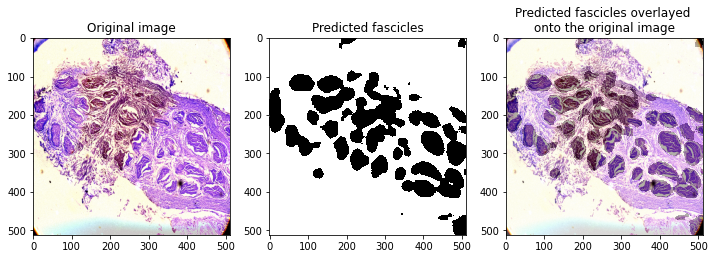

In [93]:
show_prediction(sample_1[0], trained_model_checkpoint=model_save_file, save=True)

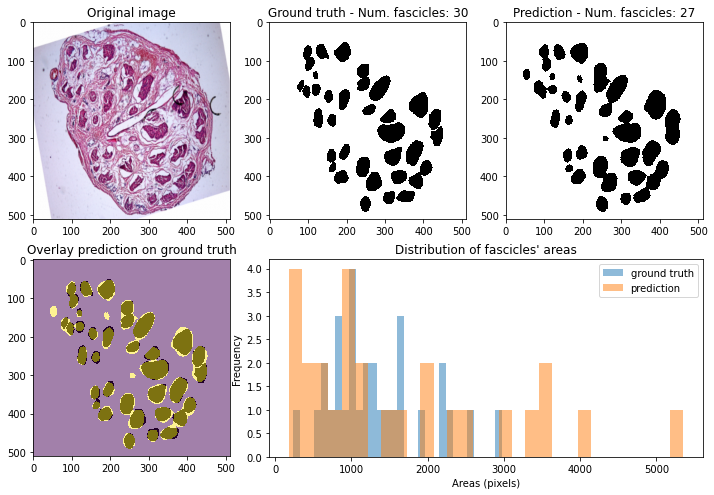

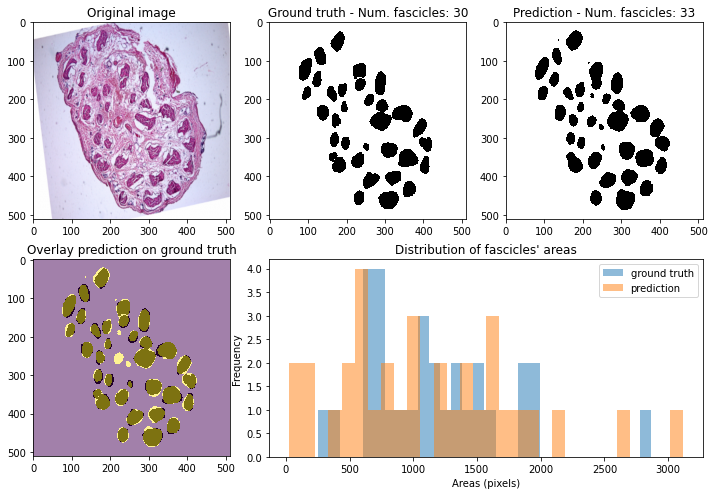

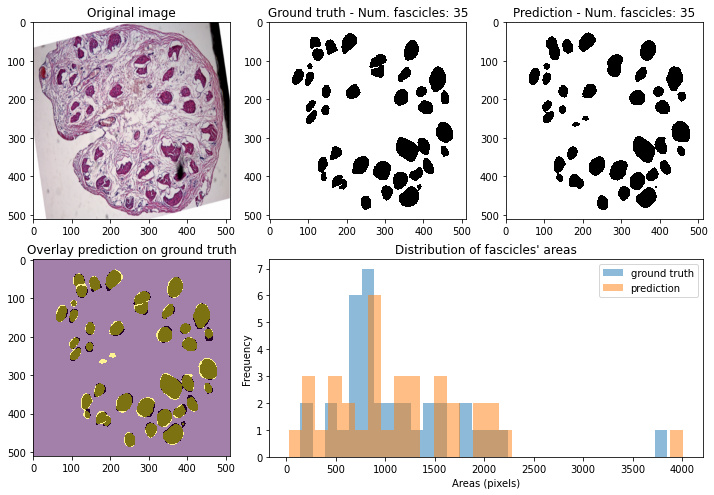

In [94]:
for (img, mask) in sample_2:
    show_mask_and_prediction(img, mask, trained_model_checkpoint=model_save_file, save=True)

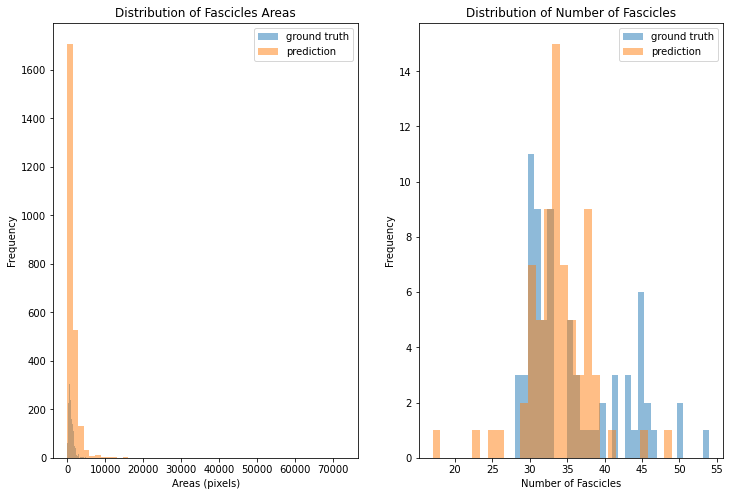

In [12]:
show_fascicles_distribution(sample_3, trained_model_checkpoint=model_save_file, save=True)

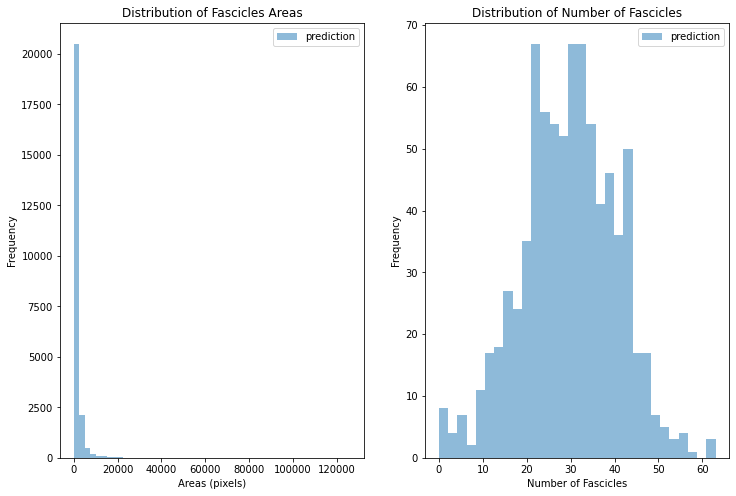

In [13]:
show_fascicles_distribution(sample_4, test=True, trained_model_checkpoint=model_save_file, save=True)

### Watershed

In [95]:
import cv2

In [96]:
def watershed(mask, coeff_list=[0.35]):
    thresh = ((1 - mask) * 255).astype('uint8')
    img = cv2.merge((thresh,thresh,thresh))
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

    axs[0][0].imshow(thresh, cmap = 'gray')
    axs[0][0].set_title('Original mask')

    # Morhphological operations to remove noise - morphological opening
    # To remove holes we can use closing, but this is not our case (or at least I think...)
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    
    axs[1][0].imshow(opening, cmap = 'gray')
    axs[1][0].set_title('Morphological opening')

    # We find what we are sure is background
    sure_bg = cv2.dilate(opening,kernel,iterations=3)

    axs[1][1].imshow(sure_bg, cmap = 'gray')
    axs[1][1].set_title('Sure background')

    num_steps = len(coeff_list)
    fig_steps, axs_steps = plt.subplots(num_steps, 3, figsize=(12, num_steps * 4))

    
    #Finding sure foreground area using distance transform and thresholding
    # intensities of the points inside the foreground regions are changed to 
    # distance their respective distances from the closest 0 value (boundary).
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    
    for i, coeff in enumerate(coeff_list):
        ret, sure_fg = cv2.threshold(dist_transform, coeff*dist_transform.max(),255,0)

        axs_steps[i][0].imshow(sure_fg, cmap = 'gray')
        axs_steps[i][0].set_title('Sure foreground')

        # Finding unknown region, the one that is not sure background and not sure foregound
        sure_fg = np.uint8(sure_fg)
        unknown = cv2.subtract(sure_bg,sure_fg)

        axs_steps[i][1].imshow(unknown, cmap = 'gray')
        axs_steps[i][1].set_title('Unknown region')

        # Marker labelling
        ret, markers = cv2.connectedComponents(sure_fg)

        # Add 10 to all labels so that sure background is not 0, but 10
        markers = markers + 10

        # Mark the region of unknown with zero
        markers[unknown==255] = 0

        # Using watershed to have the markers
        markers = cv2.watershed(img,markers)

        # We draw a red border according to the markers
        img[markers == -1] = [255,0,0]
        
        axs_steps[i][2].imshow(img)
        axs_steps[i][2].set_title('Watershed with coeff {}'.format(coeff))
    
    axs[0][1].imshow(img)
    axs[0][1].set_title('Final result')
    
    fig_steps.show()
    fig.show()

In [97]:
img_path, mask_path = get_samples(train_folder, num_samples=1)[0]
trained_model = keras.models.load_model(model_save_file)
coeff_list = [0.1, 0.2, 0.3, 0.4, 0.5]

In [98]:
img = np.load(img_path)
mask = np.load(mask_path)
pred = get_model_prediction(trained_model, np.expand_dims(img, axis=0))[0, :, :]

<ipython-input-96-110c09018d23>:67: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_steps.show()
<ipython-input-96-110c09018d23>:68: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


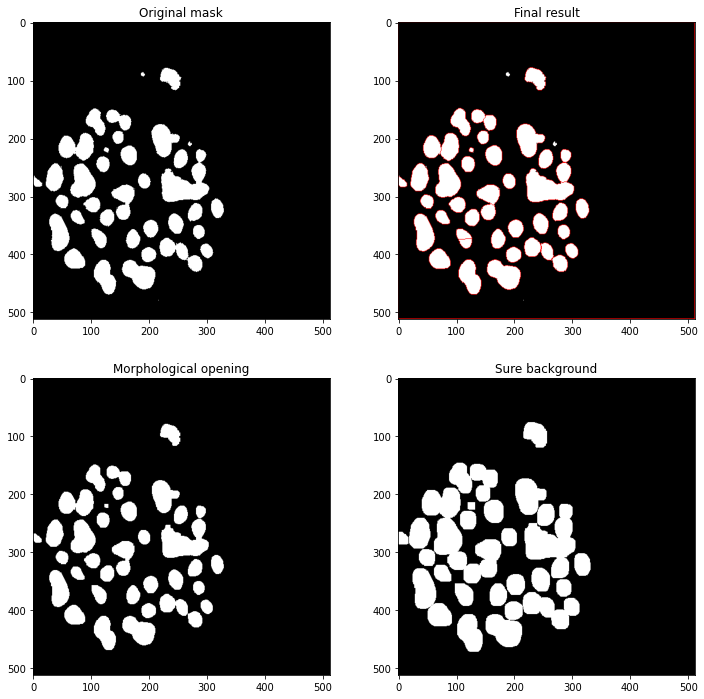

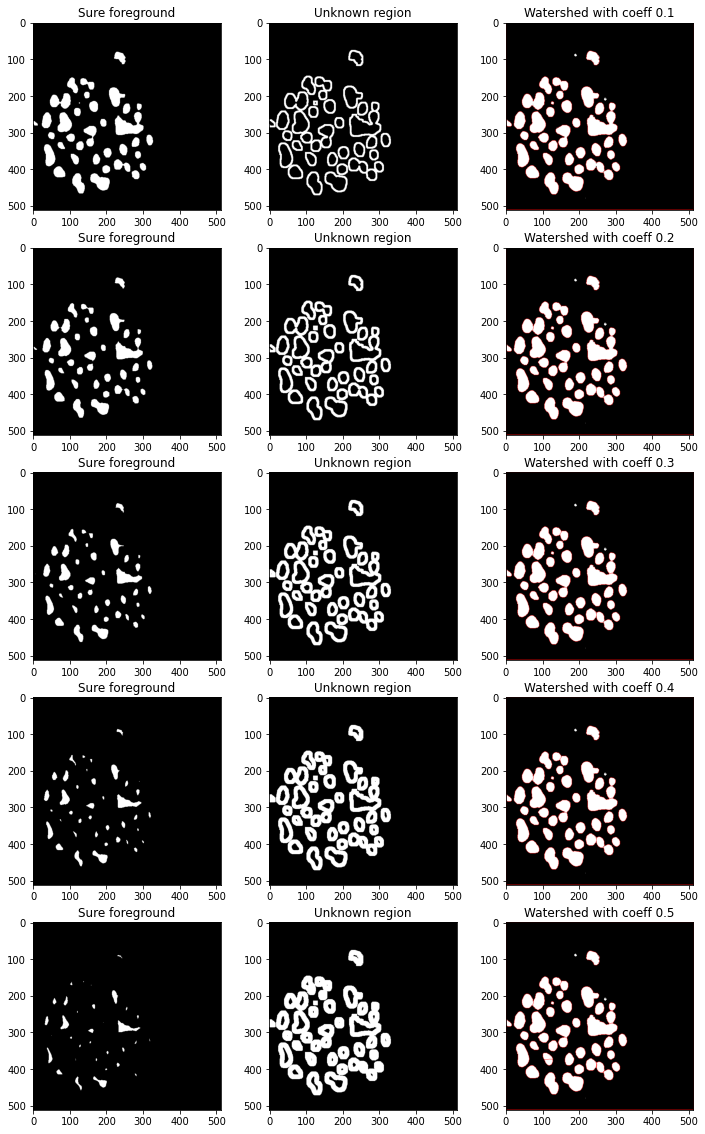

In [99]:
watershed(pred, coeff_list)

### In and Out-of-distribution images

In [100]:
unlabelled_samples = get_samples(unlabelled_folder, num_samples=10, test=True)

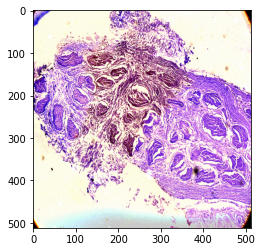

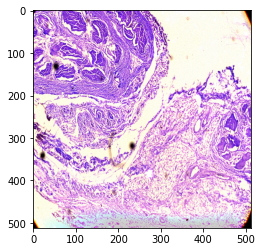

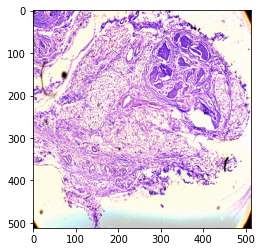

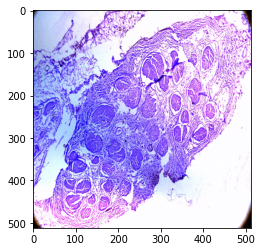

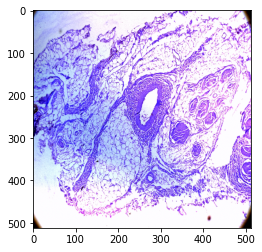

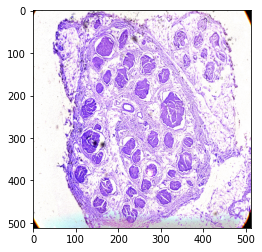

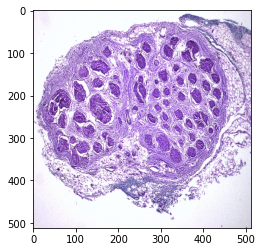

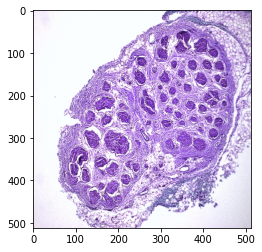

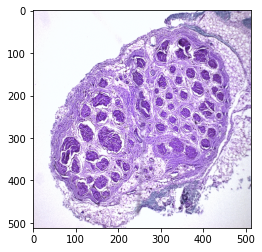

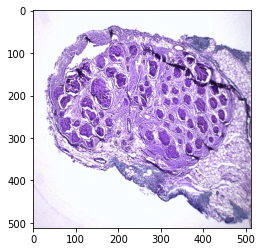

In [104]:
imgs = [np.load(s) for s in unlabelled_samples]
for img in imgs:
    plt.imshow(img)
    plt.show()

In [105]:
iod = unlabelled_samples[1:5]
print("Results for in distribution images")
for img in iod:
    show_prediction(sample_1[0], trained_model_checkpoint=model_save_file, save=True)

Results for in distribution images


In [ ]:
iod = unlabelled_samples[6:10]
print("Results for in distribution images")